In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install bayesian-optimization
!pip install 'scikit-optimize[plots]'

# **Imports**

In [4]:
import pandas as pd
import numpy as np

#data
from sklearn.model_selection import train_test_split
import pickle
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, LabelEncoder

#hyperparameter optimization
from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV 

#model
import lightgbm as lgb

#evaluation
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score, confusion_matrix

#plots
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [5]:
seed = 20210927
folds = 5

# **Data**

## **Loading and Preprocessing Data**

In [6]:
data = pd.read_csv('/content/drive/My Drive/AML/data/data.csv')

In [7]:
categorical_features = ['sex_female',  'age_0', 'age_18', 'age_50', 'age_65', 'race_native', 'race_asian', 
                        'race_black', 'race_other', 'race_native_pacific', 'race_white', 'ethnicity_hispanic',
                        'case_onset_interval', 'symptom_status', 'rural-urban_Continuum Code_2013',
                        'urban_influence_code_2013','economic_typology_2015']

In [8]:
data = data.drop(columns=['state_fips_code', 'county_fips_code', 'case_month'])
data.pop_estimate_2019 = data.pop_estimate_2019.str.replace(',', '').astype(float)
Z = data.astype(float)

for feature in categorical_features:
  Z[feature] = Z[feature].astype(int)
Z['hosp_yn'] = Z['hosp_yn'].astype(int)
Z['death_yn'] = Z['death_yn'].astype(int)

del data

X, y = Z.iloc[:, 2:], Z.iloc[:, :2]
del Z

## **Train/Test Split**

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20210927)

y_train_hosp = y_train.iloc[:, :1]
y_train_death = y_train.iloc[:, 1:2]

y_test_hosp = y_test.iloc[:, :1]
y_test_death = y_test.iloc[:, 1:2]

## **Feature Scaling**

In [10]:
pd.options.mode.chained_assignment = None  # default='warn'
X_train[X_train.columns.drop(categorical_features)] = StandardScaler().fit_transform(X_train[X_train.columns.drop(categorical_features)])
scaled_features_df_X_train = X_train
X_test[X_test.columns.drop(categorical_features)] = StandardScaler().fit_transform(X_test[X_test.columns.drop(categorical_features)])
scaled_features_df_X_test = X_test

## **Hyperparameter Optimization**

In [64]:
def bayes_parameter_opt_lgb_binary(X, y, init_round=15, opt_round=25, n_folds=folds, random_seed=seed, output_process=False):
    #prepare training data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False, categorical_feature=categorical_features)
    
    #define parameters
    def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf):
        params = {'application':'binary',  'num_boosting_round':3000, 'metric':'binary_logloss','bagging_freq' : 5}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['max_bin'] = int(round(max_depth))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['binary_logloss'], categorical_feature = categorical_features)
        #since metric is binary_logloss, which should be minimized, we take 1-min, since BayesianOptimization only has a maximize() function
        return 1.-min(cv_result['binary_logloss-mean'])
     
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                            'num_leaves': (100, 2000),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.5, 1),
                                            'max_depth': (40, 200),
                                            'max_bin':(20,90),
                                            'min_data_in_leaf': (100, 10000),
                                            'min_sum_hessian_in_leaf':(0,100)}, random_state=seed)
    
    #maximize thorugh Bayesian Optimization
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    model_auc=[]
    for model in range(len(lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
    
    # return best params
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

In [66]:
opt_params_hosp = bayes_parameter_opt_lgb_binary(scaled_features_df_X_train, y_train_hosp, init_round=5, opt_round=15, n_folds=folds, random_seed=seed)

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8103   |  0.9041   |  0.3135   |  0.2991   |  58.58    |  114.2    |  2.567e+0 |  89.89    |  1.222e+0 |
|  2        |  0.8084   |  0.6415   |  0.7582   |  0.05211  |  24.32    |  54.72    |  1.83e+03 |  14.59    |  115.1    |
|  3        |  0.806    |  0.7331   |  0.3848   |  0.9705   |  40.48    |  186.0    |  418.5    |  90.13    |  926.6    |
|  4        |  0.8075   |  0.6035   |  0.3991   |  0.04835  |  83.39    |  170.2    |  4.055e+0 |  77.53    |  1.453e+0 |
|  5        |  0.8095   |  0.8286   |  0.6091   |  0.7462   |  85.96    |  136.2    |  9.604e+0 |  86.36    |  820.0    |
|  6        |  0.8097   |  0.9352   |  0.4837   |  0.1879   |  21.97    |  40.93    |  9.985e+0 |  73.33    |  1.931e+0 |
|  7        |  0.809    

In [78]:
opt_params_death = bayes_parameter_opt_lgb_binary(scaled_features_df_X_train, y_train_death, init_round=5, opt_round=15, n_folds=folds, random_seed=seed)

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9666   |  0.9041   |  0.3135   |  0.2991   |  58.58    |  114.2    |  2.567e+0 |  89.89    |  1.222e+0 |
|  2        |  0.9653   |  0.6415   |  0.7582   |  0.05211  |  24.32    |  54.72    |  1.83e+03 |  14.59    |  115.1    |
|  3        |  0.9621   |  0.7331   |  0.3848   |  0.9705   |  40.48    |  186.0    |  418.5    |  90.13    |  926.6    |
|  4        |  0.9633   |  0.6035   |  0.3991   |  0.04835  |  83.39    |  170.2    |  4.055e+0 |  77.53    |  1.453e+0 |
|  5        |  0.9622   |  0.8286   |  0.6091   |  0.7462   |  85.96    |  136.2    |  9.604e+0 |  86.36    |  820.0    |
|  6        |  0.9661   |  0.8618   |  0.507    |  0.1683   |  27.87    |  46.37    |  9.542e+0 |  13.44    |  1.986e+0 |
|  7        |  0.9665   

In [67]:
opt_params_hosp[1]

{'bagging_fraction': 0.9040636792362207,
 'feature_fraction': 0.3135172499301264,
 'learning_rate': 0.2991274908313967,
 'max_bin': 58.57853095188194,
 'max_depth': 114.21179891130775,
 'min_data_in_leaf': 2566.6260428936253,
 'min_sum_hessian_in_leaf': 89.89353700285233,
 'num_leaves': 1221.78538134049}

In [79]:
opt_params_death[1]

{'bagging_fraction': 0.5158033798338311,
 'feature_fraction': 0.6352205390814691,
 'learning_rate': 0.14530749974186588,
 'max_bin': 88.37762674323444,
 'max_depth': 51.42571302898483,
 'min_data_in_leaf': 230.80209337237352,
 'min_sum_hessian_in_leaf': 0.24546951114261528,
 'num_leaves': 875.9841851142336}

# **Models**

## **Hospitalization Model**

In [108]:
d_train_hosp = lgb.Dataset(scaled_features_df_X_train, label=y_train_hosp)
params = {}
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['bagging_fraction'] = opt_params_hosp[1]['bagging_fraction']
params['feature_fraction'] = opt_params_hosp[1]['feature_fraction']
params['learning_rate'] = opt_params_hosp[1]['learning_rate']
params['max_bin'] = round(opt_params_hosp[1]['max_bin'])
params['max_depth'] = round(opt_params_hosp[1]['max_depth'])
params['min_data_in_leaf'] = round(opt_params_hosp[1]['min_data_in_leaf'])
params['min_sum_hessian_in_leaf']: opt_params_hosp[1]['min_sum_hessian_in_leaf']
params['num_leaves'] = round(opt_params_hosp[1]['num_leaves'])
clf_hosp = lgb.train(params, d_train_hosp, 100, categorical_feature=categorical_features)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['age_0', 'age_18', 'age_50', 'age_65', 'case_onset_interval', 'economic_typology_2015', 'ethnicity_hispanic', 'race_asian', 'race_black', 'race_native', 'race_native_pacific', 'race_other', 'race_white', 'rural-urban_Continuum Code_2013', 'sex_female', 'symptom_status', 'urban_influence_code_2013']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


### **Training Performance**

In [14]:
y_pred_train_hosp = clf_hosp.predict(scaled_features_df_X_train)

print(f'binary cross-entropy on training data: {log_loss(y_train_hosp, y_pred_train_hosp).round(6)}')
print(f'brier loss_train on training data: {brier_score_loss(y_train_hosp, y_pred_train_hosp).round(6)}')

binary cross-entropy on training data: 0.185166
brier loss_train on training data: 0.050384


## **Fatality Model**

In [80]:
d_train_death = lgb.Dataset(scaled_features_df_X_train, label=y_train_death)
params = {}
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['bagging_fraction'] = opt_params_death[1]['bagging_fraction']
params['feature_fraction'] = opt_params_death[1]['feature_fraction']
params['learning_rate'] = opt_params_death[1]['learning_rate']
params['max_bin'] = round(opt_params_death[1]['max_bin'])
params['max_depth'] = round(opt_params_death[1]['max_depth'])
params['min_data_in_leaf'] = round(opt_params_death[1]['min_data_in_leaf'])
params['min_sum_hessian_in_leaf']: opt_params_death[1]['min_sum_hessian_in_leaf']
params['num_leaves'] = round(opt_params_death[1]['num_leaves'])
clf_death = lgb.train(params, d_train_death, 100, categorical_feature=categorical_features)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['age_0', 'age_18', 'age_50', 'age_65', 'case_onset_interval', 'economic_typology_2015', 'ethnicity_hispanic', 'race_asian', 'race_black', 'race_native', 'race_native_pacific', 'race_other', 'race_white', 'rural-urban_Continuum Code_2013', 'sex_female', 'symptom_status', 'urban_influence_code_2013']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


### **Training Performance**

In [21]:
y_pred_train_death = clf_death.predict(scaled_features_df_X_train)

print(f'binary cross-entropy on training data: {log_loss(y_train_death, y_pred_train_death).round(6)}')
print(f'brier loss_train on training data: {brier_score_loss(y_train_death, y_pred_train_death).round(6)}')

binary cross-entropy on training data: 0.029281
brier loss_train on training data: 0.008408


## **Evaluation on Test Set**

In [22]:
y_pred_hosp=clf_hosp.predict(scaled_features_df_X_test)
y_pred_death=clf_death.predict(scaled_features_df_X_test)

print('Hospitalization:')
print(f'binary cross-entropy: {log_loss(y_test_hosp, y_pred_hosp).round(6)}')
print(f'brier loss: {brier_score_loss(y_test_hosp, y_pred_hosp).round(4)}')
print()
print('Fatality:')
print(f'binary cross-entropy: {log_loss(y_test_death, y_pred_death).round(6)}')
print(f'brier loss: {brier_score_loss(y_test_death, y_pred_death).round(4)}')
print()

Hospitalization:
binary cross-entropy: 0.189696
brier loss: 0.0512

Fatality:
binary cross-entropy: 0.030915
brier loss: 0.0087



## **Model Analysis**

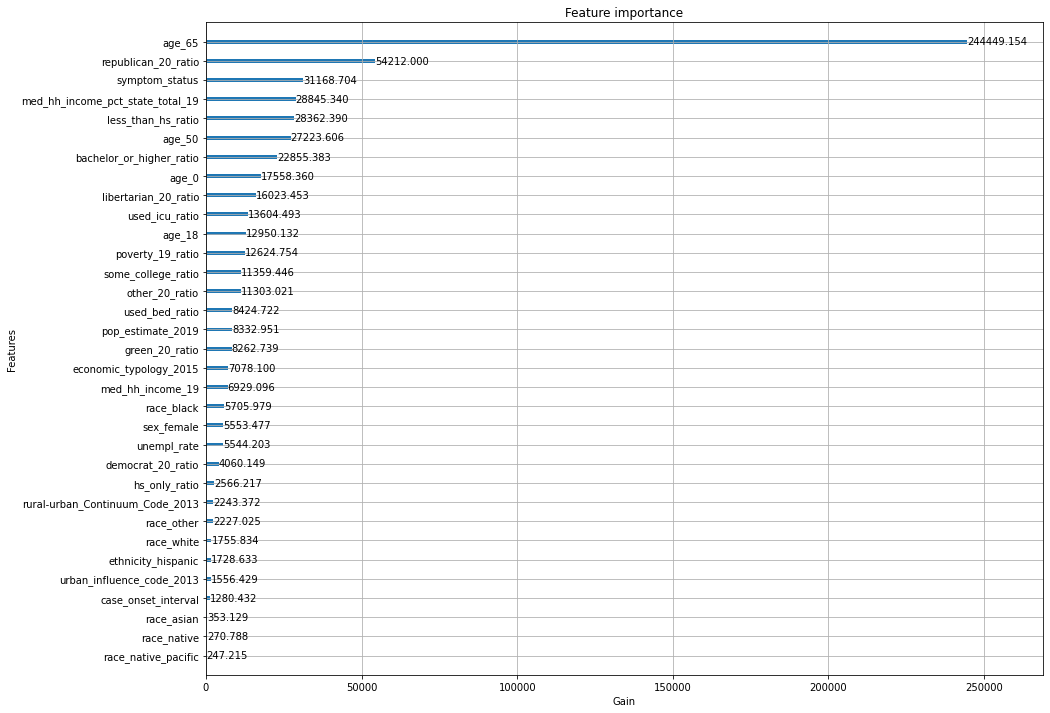

In [38]:
lgb.plot_importance(clf_hosp, figsize =(15,12),importance_type = "gain", xlabel='Gain', precision=3)

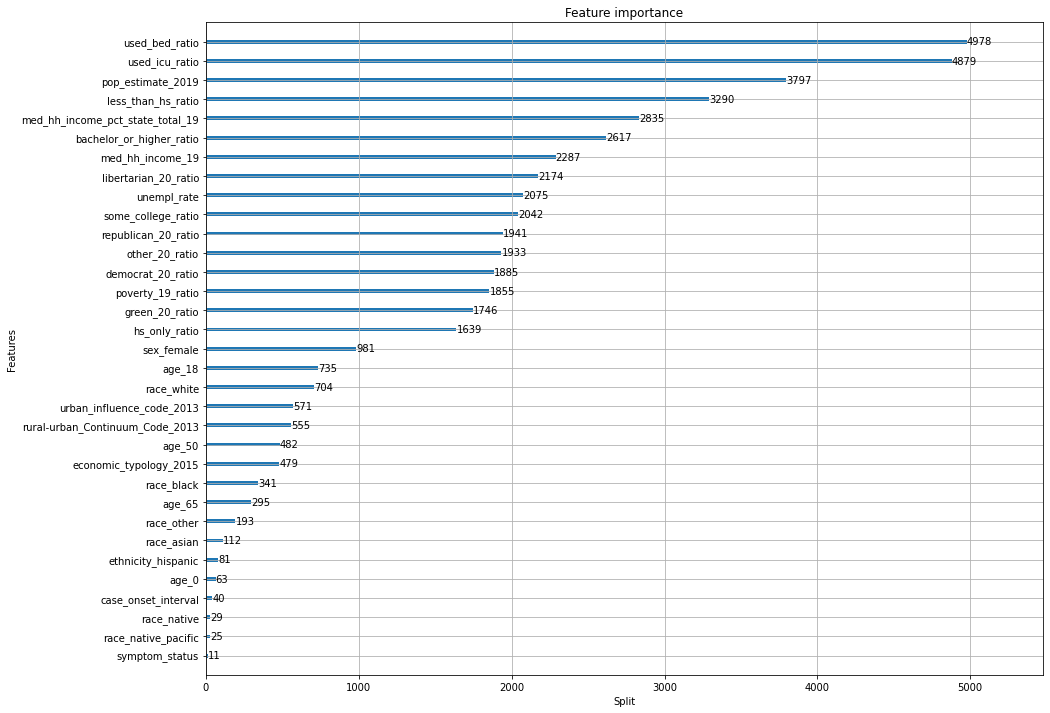

In [31]:
lgb.plot_importance(clf_hosp, figsize =(15,12),importance_type = "split", xlabel='Split')

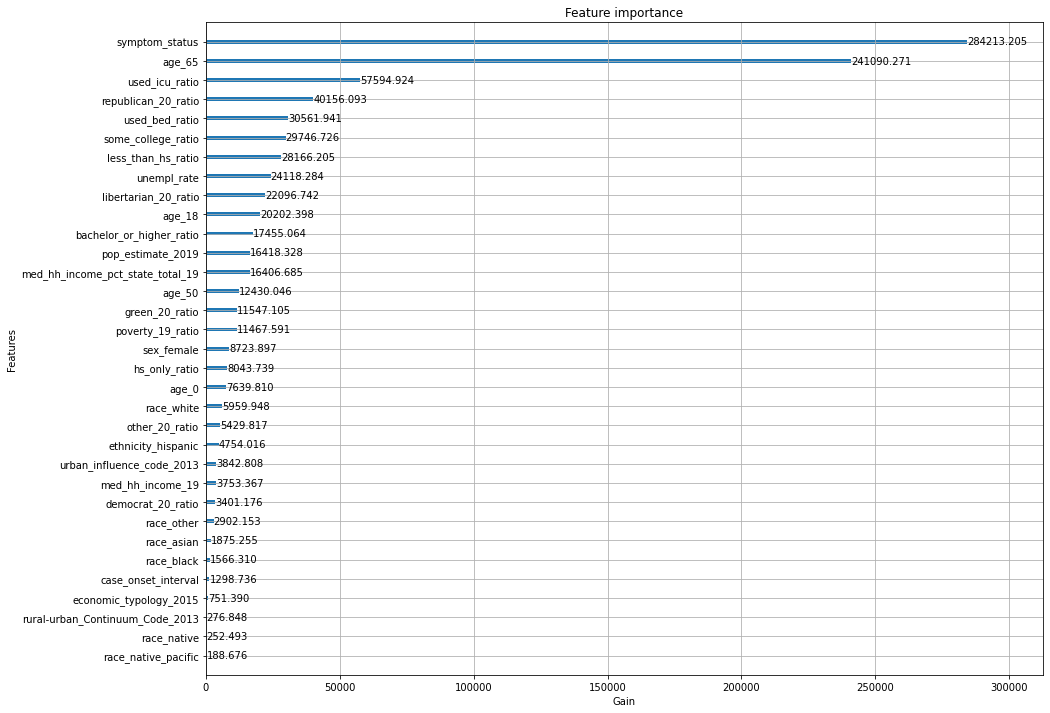

In [45]:
lgb.plot_importance(clf_death, figsize =(15,12),importance_type = "gain", xlabel='Gain', precision=3)

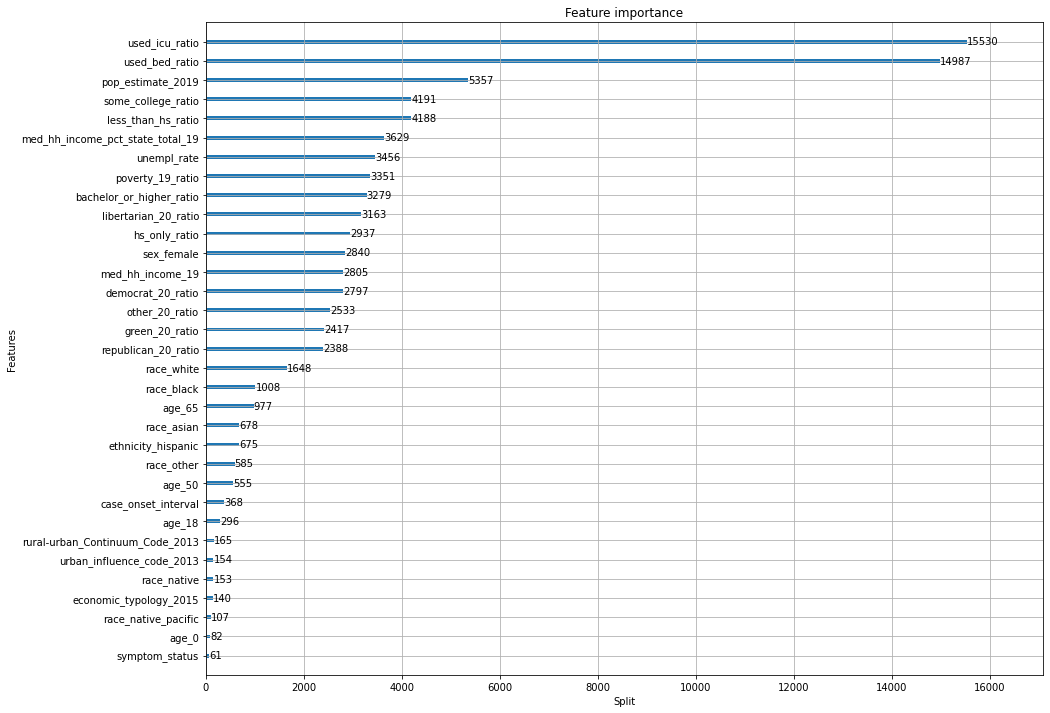

In [44]:
lgb.plot_importance(clf_death, figsize =(15,12),importance_type = "split", xlabel='Split')

In [ ]:
lgb.create_tree_digraph(clf_hosp, show_info=['split_gain', 'internal_value', 'internal_count', 'internal_weight', 'leaf_count', 'leaf_weight', 'data_percentage']) #warning: ouput is very large

In [ ]:
lgb.create_tree_digraph(clf_death, show_info=['split_gain', 'internal_value', 'internal_count', 'internal_weight', 'leaf_count', 'leaf_weight', 'data_percentage']) #warning: ouput is very large

## **Saving Final Predictions**

In [20]:
lgbm_pred = np.empty((y_pred_hosp.shape[0],2))
lgbm_pred[:,0] = y_pred_hosp
lgbm_pred[:,1] = y_pred_death

with open('/content/drive/My Drive/AML/data/lgbm.npy', 'wb') as file:
    np.save(file, lgbm_pred)